In [2]:
import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileDataset
import datetime
import matplotlib.pyplot as plt


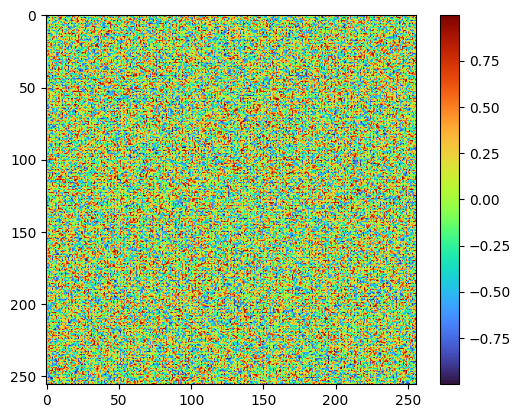

In [6]:
# Create a sample NumPy array (replace this with your actual data)
input_array = np.random.uniform(-1.0, 1.0, (256, 256)).astype(np.float32)

plt.imshow(input_array, cmap='turbo')
plt.colorbar()



In [ ]:
# Set General metadata

# Create the main dataset
ds = Dataset()

# Set required DICOM fields in the main dataset
ds.PatientName = "Test^Patient"
ds.PatientID = "123456"
ds.PatientSex = "M"
ds.PatientBirthDate = "19900101"
ds.StudyDate = "20231001"
ds.StudyTime = "120000"
ds.SeriesNumber = "1071"
ds.Manufacturer = "TestMRIScanner"
ds.InstitutionName = "Test Place"


# Recommended
# Metabolite (e.g. [1-13C]pyruvate) dynamics
# Metabolite AUC
# Metabolites (e.g. lactate/pyruvate) AUC ratio
# Pyruvate-to-lactate conversion rate (kPL)
ds.SeriesDescription = "Test Series"

ds

(0008,0020) Study Date                          DA: '20231001'
(0008,0030) Study Time                          TM: '120000'
(0008,0070) Manufacturer                        LO: 'TestMRIScanner'
(0008,0080) Institution Name                    LO: 'Test Place'
(0010,0010) Patient's Name                      PN: 'Test^Patient'
(0010,0020) Patient ID                          LO: '123456'
(0010,0030) Patient's Birth Date                DA: '19900101'
(0010,0040) Patient's Sex                       CS: 'M'
(0020,0011) Series Number                       IS: '1071'

In [8]:
# Define image geometry in the patient space
ds.ImagePositionPatient = [0.0, 0.0, 0.0]  # X, Y, Z coordinates of the first voxel
ds.ImageOrientationPatient = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]  # Direction cosines for row and column
ds.PixelSpacing = [1.0, 1.0]  # Spacing between pixels in mm (row spacing, column spacing)
ds.SliceThickness = 1.0  # Thickness of each slice in mm
ds.SliceLocation = 0.0  # Z location of the slice in mm

In [ ]:
# HP MRI specific metadata

In [9]:
# Create a DICOM dataset
def create_dicom_from_array(array, ds, filename="output.dcm"):
    file_meta = pydicom.dataset.FileMetaDataset()

    # Create a FileDataset instance
    ds = FileDataset(filename, {}, file_meta=file_meta, preamble=b"\0" * 128)

    ds.Modality = "MR"  # Other
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.SOPClassUID = pydicom.uid.MRImageStorage

    ds.ContentDate = datetime.date.today().strftime("%Y%m%d")
    ds.ContentTime = datetime.datetime.now().strftime("%H%M%S")

    # Add pixel data
    ds.Rows, ds.Columns = array.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
  
    # Normalize to use maximum dynamic range?

    # Normalize data to the range [-32768, 32767] (16-bit signed integers)
    array_max = np.max(np.abs(array))
    scaled_array = array / array_max
    int_array = (scaled_array * 32767).astype(np.int16)

    # Store the scaling factor in DICOM fields
    ds.RescaleSlope = array_max / 32767  # Scaling factor to reconstruct original values
    ds.RescaleIntercept = 0  # No offset in this case

    # Store `int_array` in the DICOM file
    ds.PixelData = int_array.tobytes()
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 1  # Signed integers
    ds.SamplesPerPixel = 1

    # Save to file
    ds.save_as(filename)
    print(f"DICOM file saved as {filename}")



In [10]:
# Call the function to create a DICOM file
create_dicom_from_array(input_array, ds)

DICOM file saved as output.dcm


(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.26536822185609201752575309974367248454
(0008,0023) Content Date                        DA: '20250403'
(0008,0033) Content Time                        TM: '104102'
(0008,0060) Modality                            CS: 'MR'
(0020,000D) Study Instance UID                  UI: 1.2.826.0.1.3680043.8.498.19121524860343199240305584549067886882
(0020,000E) Series Instance UID                 UI: 1.2.826.0.1.3680043.8.498.16287918076944332641430487215197436073
(0028,0002) Samples per Pixel                   US: 1
(0028,0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028,0010) Rows                                US: 256
(0028,0011) Columns                             US: 256
(0028,0100) Bits Allocated                      US: 16
(0028,0101) Bits Stored                         US: 16
(0028,0102) High Bit                            US: 15
(0

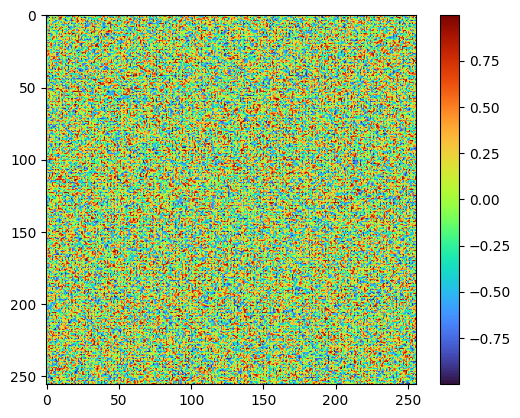

In [12]:
# Read the DICOM file to verify
ds_out = pydicom.dcmread("output.dcm")
print(ds_out)

# Check the pixel data
pixel_data = np.frombuffer(ds_out.PixelData, dtype=np.int16)
pixel_data = pixel_data.reshape(ds_out.Rows, ds_out.Columns)

scaling_factor_out = ds_out.RescaleSlope

# plot a colormap version of the images
plt.imshow(pixel_data * scaling_factor_out, cmap='turbo')
plt.colorbar()